##Monta o drive e importa as bibliotecas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importa as bibliotecas essenciais
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import tifffile
import skimage as ski
from skimage.filters import threshold_multiotsu
from skimage import data, io
from skimage import exposure # Módulo onde o CLAHE está

##Saber quantos bits tem a imagem

In [ ]:
#Saber quantos bits é minha imagem
from PIL import Image

def get_tiff_bit_depth_pillow(image_path):
    """
    Retorna a profundidade de bits de uma imagem TIFF usando Pillow.
    """
    try:
        with Image.open(image_path) as img:
            # O atributo 'mode' da imagem PIL indica o tipo e a profundidade de bits.
            # Por exemplo:
            # 'L'  -> 8-bit grayscale
            # 'I'  -> 32-bit signed integer pixels
            # 'F'  -> 32-bit floating point pixels
            # 'I;16' -> 16-bit unsigned integer (little-endian)
            # 'RGB' -> 24-bit true color (8 bits por canal)
            # 'RGBA' -> 32-bit true color with transparency (8 bits por canal + alpha)

            mode = img.mode
            bands = img.getbands()

            if mode == '1':
                return 1 # 1-bit binary image
            elif mode == 'L':
                return 8 # 8-bit grayscale
            elif mode == 'P':
                return 8 # 8-bit palettized
            elif mode == 'I':
                return 32 # 32-bit signed integer
            elif mode == 'F':
                return 32 # 32-bit floating point
            elif mode.startswith('I;'): # Formato comum para TIFFs de 16-bit
                if '16' in mode:
                    return 16
                elif '32' in mode:
                    return 32
                elif '64' in mode:
                    return 64
                else:
                    print(f"Modo TIFF específico encontrado: {mode}. Pode indicar uma profundidade de bits diferente.")
                    # Tentar deduzir pelo itemsize do array numpy se converter
                    # (ver exemplo OpenCV ou converter para numpy)
                    return None
            elif 'RGB' in mode or 'CMYK' in mode or 'YCbCr' in mode:
                # Para modos como RGB, RGBA, CMYK, YCbCr, geralmente são 8 bits por canal.
                # Multiplicamos pelo número de canais.
                return len(bands) * 8
            else:
                print(f"Modo de imagem desconhecido: {mode}")
                return None

    except FileNotFoundError:
        print(f"Erro: O arquivo '{image_path}' não foi encontrado.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro ao abrir a imagem: {e}")
        return None

# Exemplo de uso:
image_path = "/content/drive/Othercomputers/Meu laptop/Desktop/thresholds/A12388-campo1-ROI1-S-mansoni-30dias-240mW-shg-acc7.tif"  # Substitua pelo caminho da sua imagem TIFF
bit_depth = get_tiff_bit_depth_pillow(image_path)

if bit_depth is not None:
    print(f"A profundidade de bits da imagem {image_path} é: {bit_depth} bits.")

Erro: O arquivo '/content/drive/Othercomputers/Meu laptop/Desktop/thresholds/A12388-campo1-ROI1-S-mansoni-30dias-240mW-shg-acc7.tif' não foi encontrado.


##Caminho e nome da imagem

In [ ]:
file_path = os.path.join(ski.data_dir,'/content/drive/MyDrive/Mestrado/Schistossoma/thresholds/working23052025/Imagem/') #caminho da imagem
archive_name = 'A12388-campo1-ROI7-S-mansoni-30dias-240mW-shg-acc7.tif'
img = ski.io.imread(file_path+archive_name)[:,:,0]    #carrega a imagem

## Aplicando a otimização de contraste local

###Código explicado, com imagens e histogramas

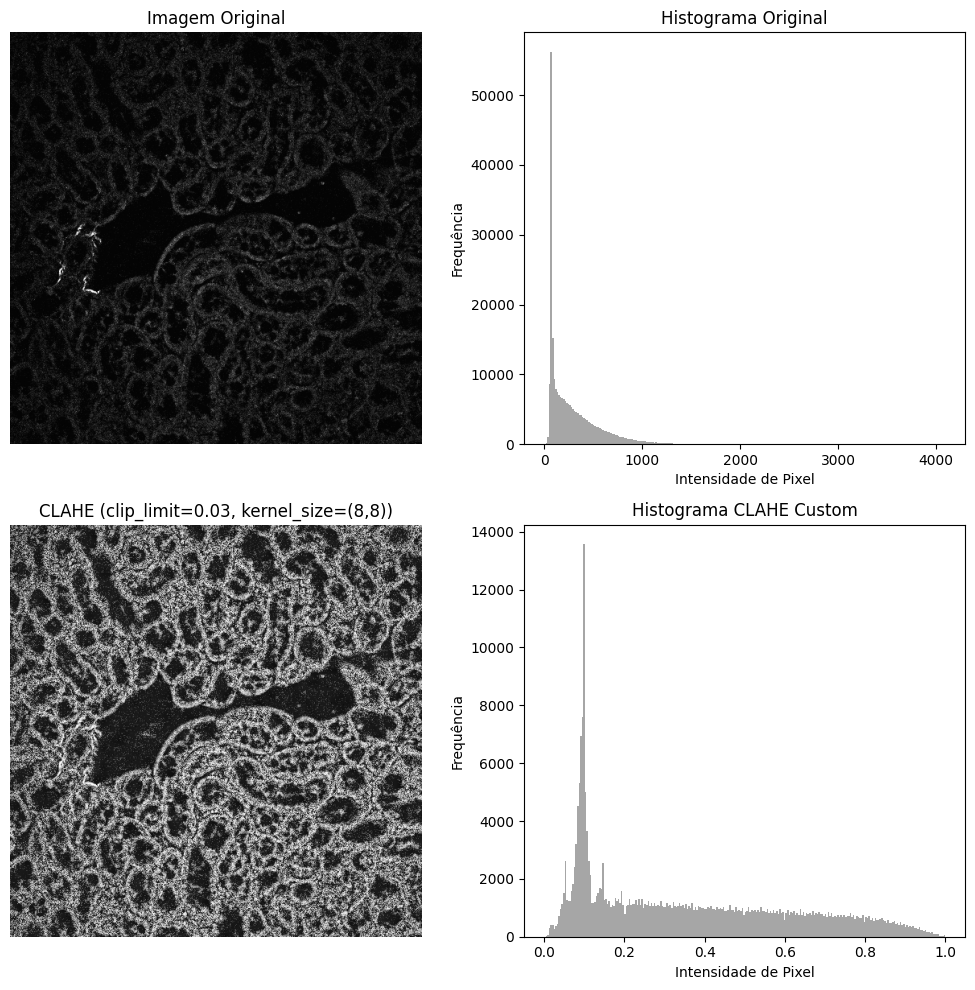

In [ ]:
try:
    img = ski.io.imread(file_path+archive_name)[:,:,0]    #carrega a imagem

except FileNotFoundError:
    print("Arquivo 'sua_imagem.tif' não encontrado. Gerando uma imagem de teste.")
    # Gerar uma imagem de teste para demonstração
    # Criando uma imagem com um quadrado brilhante e um fundo com gradiente sutil
    img = np.zeros((200, 200), dtype=np.uint8)
    # Fundo com um gradiente suave (simulando PL)
    for i in range(200):
        img[i, :] = int(50 + 0.5 * i)
    # Área de SHG (muito mais brilhante e pequena)
    img[80:120, 80:120] = 200
    img[10:30, 150:170] = 255 # Outra região de SHG
    img[170:180, 20:30] = 240 # Outra região de SHG


# --- 2. Aplicar CLAHE ---
# `exposure.equalize_adapthist` é a função para CLAHE
# Parâmetros importantes:
# - `clip_limit`: Valor entre 0 e 1. Quanto menor, mais suave a equalização.
#                  Um valor de 0.01 significa que os picos do histograma serão
#                  cortados em 1% do número total de pixels na região.
#                  Experimente valores como 0.01, 0.02, 0.03, etc.
# - `nbins`: Número de bins para o histograma de cada região. Geralmente 256.
# - `kernel_size`: Tamanho da janela (tile) para equalização. Pode ser um inteiro
#                  (para janelas quadradas) ou uma tupla (altura, largura).
#                  Valores típicos são (8,8), (16,16), (32,32) ou até maiores.
#                  Escolha um tamanho que seja maior que os detalhes que você quer realçar,
#                  mas menor que a imagem toda.

#Ajustando `kernel_size` e `clip_limit`
# Um `kernel_size` menor para realçar detalhes muito pequenos
# Um `clip_limit` um pouco maior para um contraste mais agressivo, se necessário
clahe_img_custom= exposure.equalize_adapthist(img, clip_limit=0.05, kernel_size=(8, 8))

# --- 3. Visualizar Resultados e Histogramas ---
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Imagem Original')
ax[0].axis('off')

ax[1].hist(img.ravel(), bins=256, color='gray', alpha=0.7)
ax[1].set_title('Histograma Original')
ax[1].set_xlabel('Intensidade de Pixel')
ax[1].set_ylabel('Frequência')

ax[2].imshow(clahe_img_custom, cmap='gray')
ax[2].set_title('CLAHE (clip_limit=0.03, kernel_size=(8,8))')
ax[2].axis('off')

ax[3].hist(clahe_img_custom.ravel(), bins=256, color='gray', alpha=0.7)
ax[3].set_title('Histograma CLAHE Custom')
ax[3].set_xlabel('Intensidade de Pixel')
ax[3].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

###Código objetivo

In [ ]:
img = ski.io.imread(file_path+archive_name)[:,:,0]
clahe_img_custom= exposure.equalize_adapthist(img, clip_limit=0.05, kernel_size=(8, 8))

##Reescalonamento dos dados do CLAHE

In [ ]:
# Note que `exposure.equalize_adapthist` retorna uma imagem float no intervalo [0, 1]. É preciso reescalonar para o intervalo [0,4095]

def rescale(data, min_value, max_value):
  try:
    data_min, data_max = data.min(), data.max()
    data_scaled = np.round((data - data_min) * (max_value - min_value) / (data_max - data_min) + min_value)
    data_scaled[data_scaled > max_value] = max_value          #Garante que após o arredondamento nenhum valor seja superior ao valor máximo definido
    return data_scaled.astype(np.uint16)
  except Exception as e:
    print('Ocorreu um erro inesperado: {}'.format(e))
    return None
rescaled_clahe_img_custom = rescale(clahe_img_custom, 0, 4095)

### Verifica o reescalonamento por meio de um novo histograma

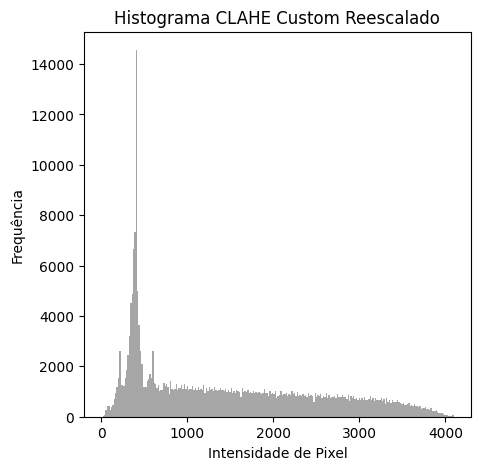

In [ ]:
#Verificando os dados reescalados, em novo histograma
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(rescaled_clahe_img_custom.ravel(), bins=256, color='gray', alpha=0.7)
ax.set_title('Histograma CLAHE Custom Reescalado')
ax.set_xlabel('Intensidade de Pixel')
ax.set_ylabel('Frequência')
plt.show()

##Aplicando o threshold após o CLAHE

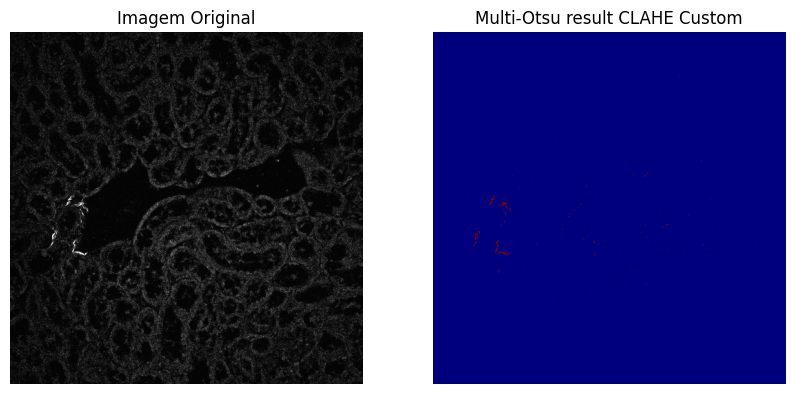

<Figure size 1000x500 with 0 Axes>

Threshold Otsu aplicado na imagem CLAHE: [1688]


In [ ]:
otsu_threhold_clahe_custom = threshold_multiotsu(rescaled_clahe_img_custom, classes=2)

regions_clahe_custom = np.digitize(img, bins=otsu_threhold_clahe_custom)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.figure(figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Imagem Original')
ax[0].axis('off')
ax[1].imshow(regions_clahe_custom, cmap='jet')
ax[1].set_title('Multi-Otsu result CLAHE Custom')
ax[1].axis('off')
plt.show()

print('Threshold Otsu aplicado na imagem CLAHE: {}'.format(otsu_threhold_clahe_custom))

In [ ]:
def rescale(data, min_value, max_value):
  try:
    data_min, data_max = data.min(), data.max()
    data_scaled = np.round((data - data_min) * (max_value - min_value) / (data_max - data_min) + min_value)
    data_scaled[data_scaled > max_value] = max_value          #Garante que após o arredondamento nenhum valor seja superior ao valor máximo definido
    return data_scaled.astype(np.uint16)
  except Exception as e:
    print('Ocorreu um erro inesperado: {}'.format(e))
    return None

def calculate_treshold_and_variance_between_classes(image):
  '''Calcula o threshold que maximiza a variância entre classes (método de Otsu),
     assim como a variância máxima, para duas classes somente'''
  intensity, count = np.unique(image, return_counts=True)

  n = len(intensity)

  probability = count/count.sum()

  cumulative_probability = probability.cumsum()

  E_i = intensity * probability

  partial_weighted_sum = E_i.cumsum()

  global_mean = E_i.sum()

  mean_C1 = np.zeros_like(intensity, dtype=float)

  cumulative_probability_C1 = np.zeros_like(intensity, dtype=float)

  mean_C0 = partial_weighted_sum/cumulative_probability

  mean_C1[:-1] = (partial_weighted_sum[-1] - partial_weighted_sum[:-1]) / (1 - cumulative_probability[:-1])

  cumulative_probability_C1[:-1] = 1 - cumulative_probability[:-1]

  variance_between_classes = cumulative_probability*(global_mean - mean_C0)**2+cumulative_probability_C1*(global_mean-mean_C1)**2

  indice_maior_valor = np.argmax(variance_between_classes)

  return intensity[indice_maior_valor], variance_between_classes[indice_maior_valor]


def find_best_parameters(image):
  clip_limits_to_try = np.arange(0.01,0.21,0.01)
  kernel_sizes_to_try = [(8,8),(16,16),(32,32)]
  clip_limits_index, kernel_sizes_index = np.meshgrid(np.arange(len(clip_limits_to_try)), np.arange(len(kernel_sizes_to_try)))
  clip_limits_index, kernel_sizes_index = clip_limits_index.flatten(), kernel_sizes_index.flatten()
  clip_limits = clip_limits_to_try[clip_limits_index]
  kernel_sizes = [kernel_sizes_to_try[i] for i in kernel_sizes_index]
  results = [
    calculate_treshold_and_variance_between_classes(
        rescale(exposure.equalize_adapthist(image, clip_limit=clip_limits[i], kernel_size=kernel_sizes[i]), 0, 4095)
    )
    for i in range(len(clip_limits))
  ]
  thresholds, variances = zip(*results)
  return int(thresholds[np.argmax(variances)])
  '''print(clip_limits)
  print(kernel_sizes)'''


find_best_parameters(img)


NameError: name 'img' is not defined

Preciso de uma métrica que permita estimar o melhor valor para os parâmetros clip_limit e tamanho da janela! Preciso anotar os valores de thresholds obtidos originalmente para cada uma das imagens, com os respectivos números de classes que permitem separar o sinal de SHG, inclusive para a imagem para a qual houve a necessidade de fazer um corte e aplicar o Multi-Otsuo ao corte!Isso facilita na hora de comparar a performance do método e se houve ganho de informação ao aplicar a otimização de contraste local. A ideia de empregar uma ou mais métricas é encontrar os melhores valores de clip_limit e kernel_size que otimizam essa métrica! Uma excelente ideia é usar a maximização da variância interclasses do método de Otsuo como ponto de partida. Então, o ideal seria criar um conjunto de valores possíveis para clip_limit e kernel_size, aplicar o CLAHE para cada par de valores, calcular a variância interclasses e usar como parâmetros ideias para o CLAHE aqueles que maximizam a variância!

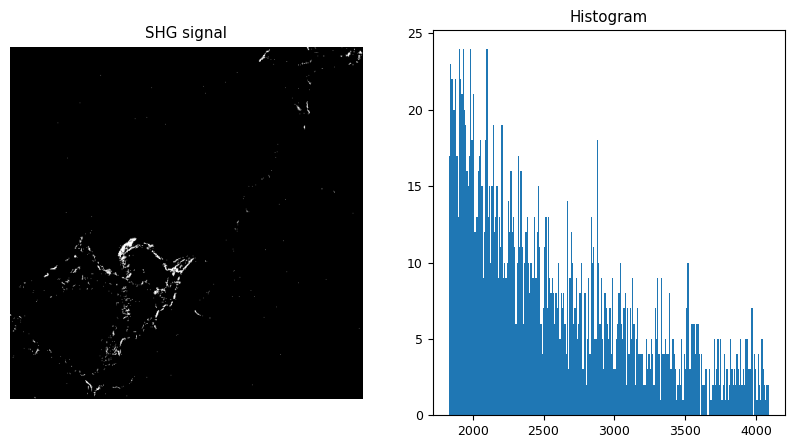

In [ ]:
#import cv2
# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = first_image[:,:,0]

# Flatten the image to a 1D array of pixel values
pixels = image.ravel()

# Max intensity
max_intensity = pixels.max()

# Filter out pixels with a value of 0 or max intensity
non_zero_pixels = pixels[(pixels != 0) & (pixels != max_intensity)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('SHG signal')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.

#pixels = image.ravel()
#histograma = np.bincount(pixels)              #Ignora os pixels com intensidade nula
#masked_image = image.ravel()[image.ravel() != histograma[np.argmax(histograma)]]

ax[1].hist(non_zero_pixels, bins=255)
ax[1].set_title('Histogram')


plt.subplots_adjust()
plt.show()

$$
\begin{array}{|c|c|c|}
\hline
\textbf{Imagem} & \textbf{Threshold original} & \textbf{Threshold com CLAHE} \\ \hline
\textbf{ROI1}   & 1851                        & 1747                         \\ \hline
\textbf{ROI2}   & 1738                        & 1668                         \\ \hline
\textbf{ROI4}   & 2333                        & 1704                         \\ \hline
\textbf{ROI7}   & 1703                        & 1820                         \\ \hline
\end{array}
$$